Found 8204 images belonging to 18 classes.
Found 1751 images belonging to 18 classes.
Found 1782 images belonging to 18 classes.


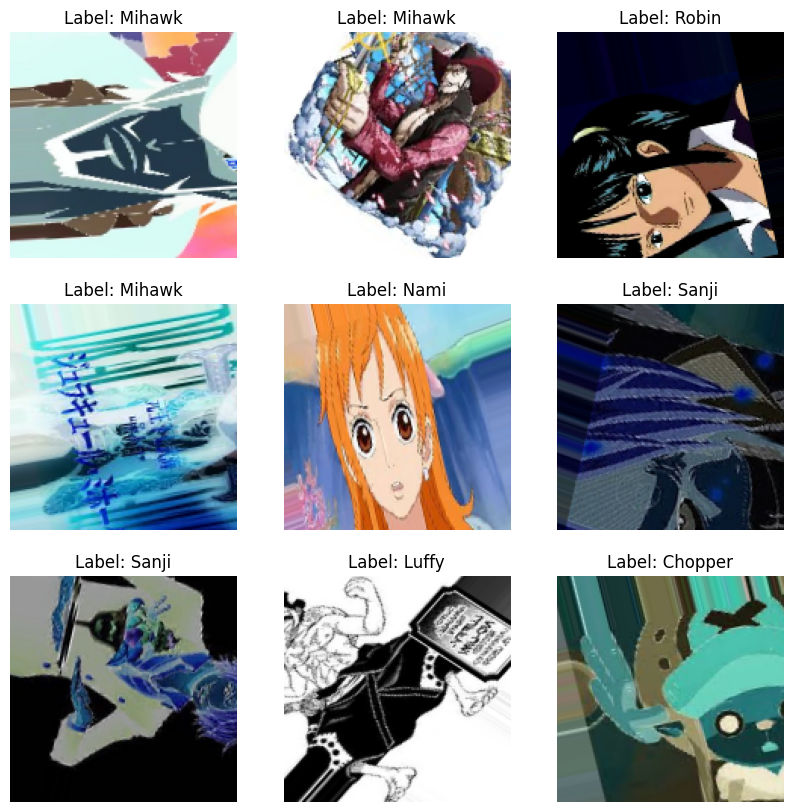

In [1]:
import os
import shutil
import numpy as np
import pickle
import keras
from sklearn.metrics import precision_score, recall_score, f1_score
import logging
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os

classes = {
        0: 'Ace',
        1: 'Akainu',
        2: 'Brook',
        3: 'Chopper',
        4: 'Crocodile',
        5: 'Franky',
        6: 'Jinbei',
        7: 'Kurohige',
        8: 'Law',
        9: 'Luffy',
        10: 'Mihawk',
        11: 'Nami',
        12: 'Rayleigh',
        13: 'Robin',
        14: 'Sanji',
        15: 'Shanks',
        16: 'Usopp',
        17: 'Zoro',
    }

def create_directories(base_dir, categories):
    """
    Create directories for training, testing, and validation datasets.

    Parameters:
    - base_dir (str): The base directory where the train, test, and validation directories will be created.
    - categories (list): List of category names (sub-directory names) to create inside each of train, test, and validation directories.
    """
    for subset in ['train', 'test', 'validation']:
        for category in categories:
            dir_path = os.path.join(base_dir, subset, category)
            os.makedirs(dir_path, exist_ok=True)
            logging.info(f'Created directory: {dir_path}')

def copy_images(source_dir, images, dest_dir):
    """
    Copy images from source directory to destination directory.

    Parameters:
    - source_dir (str): The directory containing the source images.
    - images (list): List of image filenames to copy.
    - dest_dir (str): The destination directory where images will be copied.
    """
    for image in images:
        shutil.copy(os.path.join(source_dir, image), os.path.join(dest_dir, image))
        logging.info(f'Copied {image} to {dest_dir}')

def split_dataset(source_dir, base_dir, split_ratios=(0.7, 0.15, 0.15)):
    """
    Split the dataset into training, testing, and validation sets.

    Parameters:
    - source_dir (str): The source directory containing subdirectories of images for each category.
    - base_dir (str): The base directory where the split datasets will be stored.
    - split_ratios (tuple): A tuple containing the ratios for splitting the dataset into train, test, and validation sets.

    Raises:
    - ValueError: If the split ratios do not sum to 1.
    """
    if sum(split_ratios) != 1:
        raise ValueError("Split ratios must sum to 1. Provided ratios sum to {:.2f}".format(sum(split_ratios)))
    
    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    create_directories(base_dir, categories)

    for category in categories:
        category_path = os.path.join(source_dir, category)
        images = os.listdir(category_path)
        np.random.shuffle(images)

        train_split = int(len(images) * split_ratios[0])
        test_split = int(len(images) * split_ratios[1])

        train_images = images[:train_split]
        test_images = images[train_split:train_split + test_split]
        validation_images = images[train_split + test_split:]

        copy_images(category_path, train_images, os.path.join(base_dir, 'train', category))
        copy_images(category_path, test_images, os.path.join(base_dir, 'test', category))
        copy_images(category_path, validation_images, os.path.join(base_dir, 'validation', category))
        
def preprocess_image(image_path):
    img = Image.open(image_path)
    if img.mode == 'P' and 'transparency' in img.info:
        img = img.convert('RGBA')
        img = img.convert('RGB')
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    return img

def setup_and_split_dataset(source_dir='Data', base_dir='Dataset_Split', split_ratios=(0.7, 0.15, 0.15)):
    """
    Set up logging, define directories, and split the dataset.

    Parameters:
    - source_dir (str): The source directory containing subdirectories of images for each category.
    - base_dir (str): The base directory where the split datasets will be stored.
    - split_ratios (tuple): A tuple containing the ratios for splitting the dataset into train, test, and validation sets.
    """
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    try:
        split_dataset(source_dir, base_dir, split_ratios)
    except ValueError as e:
        logging.error(e)
        
def load_dataset(base_dir, target_size=(150, 150), batch_size=32, augmentation=False):
    """
    Load the dataset into variables using ImageDataGenerator.

    Parameters:
    - base_dir (str): The base directory where the split datasets are stored.
    - target_size (tuple): The dimensions to which all images found will be resized.
    - batch_size (int): Size of the batches of data (default: 32).
    - augmentation (bool): Whether to apply data augmentation to the training dataset (default: False).

    Returns:
    - train_generator (DirectoryIterator): Iterator for training dataset.
    - test_generator (DirectoryIterator): Iterator for testing dataset.
    - validation_generator (DirectoryIterator): Iterator for validation dataset.
    """
    if augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(base_dir, 'validation'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

    return train_generator, test_generator, validation_generator

def display_images(images, labels, classes):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i]
        if image.shape[-1] == 3:
            image = np.clip(image * 255, 0, 255).astype("uint8")
        plt.imshow(image)
        class_name = classes[labels[i].argmax()]
        plt.title(f"Label: {class_name}")
        plt.axis("off")
    plt.show()

if __name__ == "__main__":
    #setup_and_split_dataset()
    
    base_dir = 'Dataset_Split'
    train_generator, test_generator, validation_generator = load_dataset(base_dir, augmentation=True)

    images, labels = next(train_generator)
    display_images(images, labels, classes)


In [2]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dense(18, activation='sigmoid')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,042,898 (72.64 MB)

 Trainable params: 19,042,898 (72.64 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
history = model.fit(train_generator, epochs=40, validation_data=validation_generator)

Epoch 1/40


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 46/257 ━━━━━━━━━━━━━━━━━━━━ 1:28 419ms/step - acc: 0.0527 - loss: 3.1763

c:\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


257/257 ━━━━━━━━━━━━━━━━━━━━ 124s 471ms/step - acc: 0.0780 - loss: 2.9267 - val_acc: 0.1493 - val_loss: 2.7221
Epoch 2/40
257/257 ━━━━━━━━━━━━━━━━━━━━ 116s 447ms/step - acc: 0.1733 - loss: 2.6347 - val_acc: 0.2071 - val_loss: 2.4863
Epoch 3/40
257/257 ━━━━━━━━━━━━━━━━━━━━ 114s 438ms/step - acc: 0.2400 - loss: 2.4096 - val_acc: 0.2682 - val_loss: 2.3350
Epoch 4/40
257/257 ━━━━━━━━━━━━━━━━━━━━ 115s 441ms/step - acc: 0.3055 - loss: 2.2355 - val_acc: 0.3288 - val_loss: 2.2292
Epoch 5/40
257/257 ━━━━━━━━━━━━━━━━━━━━ 123s 473ms/step - acc: 0.3544 - loss: 2.0981 - val_acc: 0.3709 - val_loss: 2.0782
Epoch 6/40
257/257 ━━━━━━━━━━━━━━━━━━━━ 123s 471ms/step - acc: 0.4021 - loss: 1.9435 - val_acc: 0.3569 - val_loss: 2.7046
Epoch 7/40
257/257 ━━━━━━━━━━━━━━━━━━━━ 122s 466ms/step - acc: 0.4224 - loss: 1.8572 - val_acc: 0.4394 - val_loss: 1.9161
Epoch 8/40
257/257 ━━━━━━━━━━━━━━━━━━━━ 122s 468ms/step - acc: 0.4693 - loss: 1.7417 - val_acc: 0.4753 - val_loss: 1.7976
Epoch 9/40
257/257 ━━━━━━━━━━━━━━━━

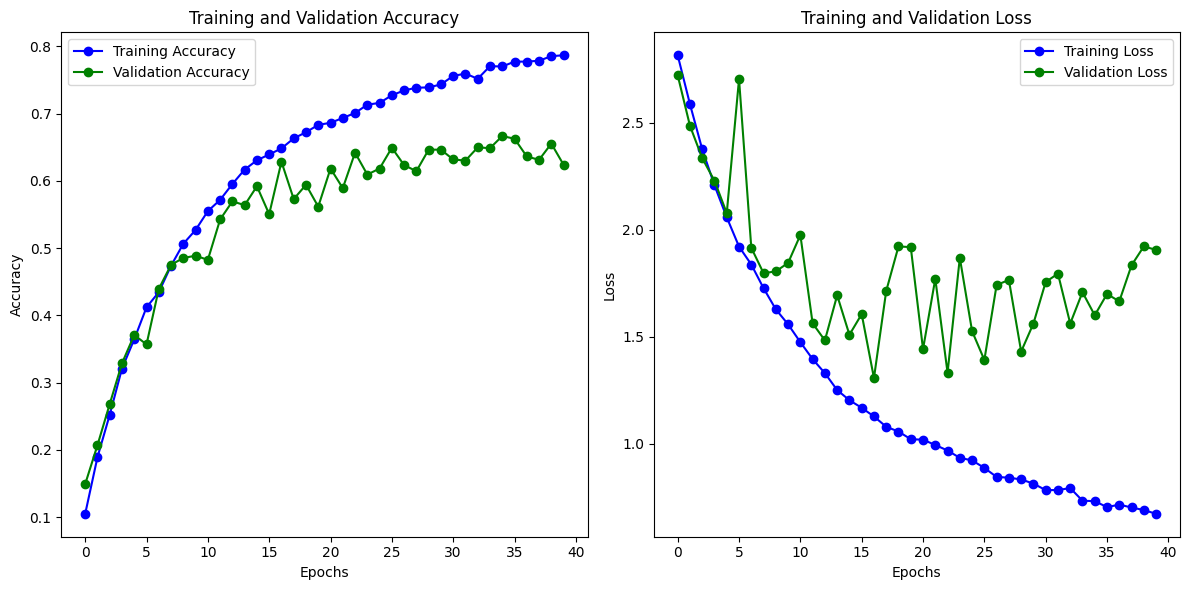

  7/257 ━━━━━━━━━━━━━━━━━━━━ 1:13 292ms/step

c:\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


257/257 ━━━━━━━━━━━━━━━━━━━━ 68s 264ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step


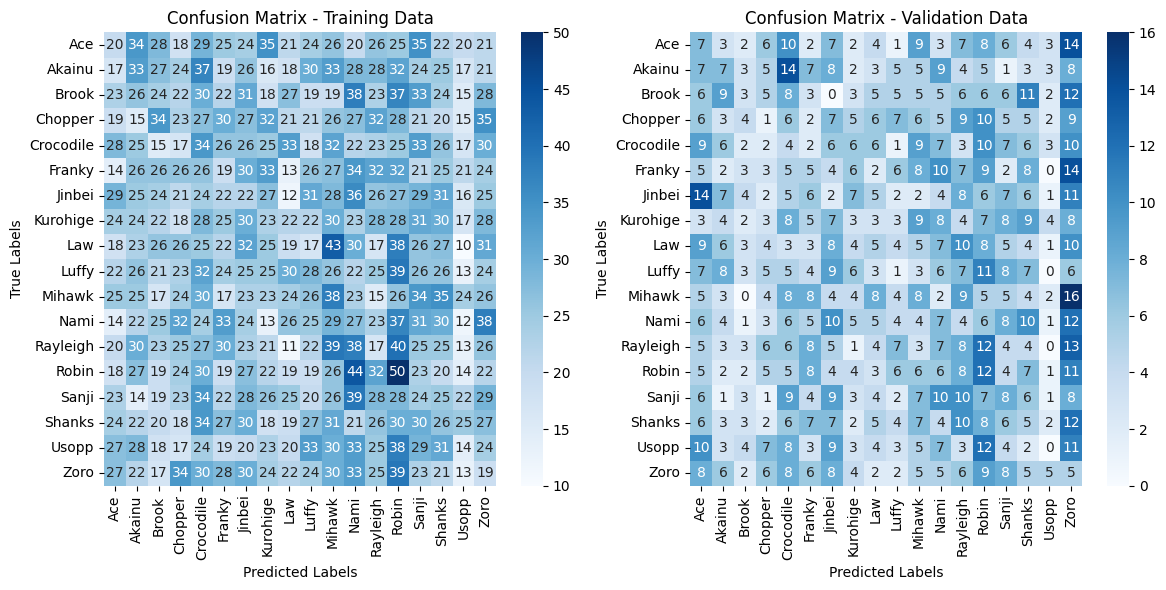

12/56 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step

c:\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step
Accuracy:  0.04938271604938271
Precision: 0.0499
Recall: 0.0494
F1-score: 0.0468


In [6]:
def plot_history(history):
    training_accuracy = history.history['acc']
    validation_accuracy = history.history['val_acc']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(training_accuracy, label='Training Accuracy', color='blue', linestyle='-', marker='o')
    axes[0].plot(validation_accuracy, label='Validation Accuracy', color='green', linestyle='-', marker='o')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(training_loss, label='Training Loss', color='blue', linestyle='-', marker='o')
    axes[1].plot(validation_loss, label='Validation Loss', color='green', linestyle='-', marker='o')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()

    plt.show()

def save_history(history, filename):
    """Save the history object to a file."""
    with open(filename, 'wb') as file:
        pickle.dump(history.history, file)
    print(f"History object saved successfully in {filename}")
    
def load_history(filename):
    """Load the history object from a file."""
    with open(filename, 'rb') as file:
        history = pickle.load(file)
    print(f"History object loaded successfully from {filename}")
    return history

def plot_confusion_matrices(model, train_generator, validation_generator, classes):
    """Plot confusion matrices for training and validation data."""
    y_pred_train = model.predict(train_generator)
    y_pred_validation = model.predict(validation_generator)

    y_pred_train_classes = np.argmax(y_pred_train, axis=1)
    y_pred_validation_classes = np.argmax(y_pred_validation, axis=1)

    y_true_train = train_generator.classes
    y_true_validation = validation_generator.classes

    cm_train = confusion_matrix(y_true_train, y_pred_train_classes)
    cm_validation = confusion_matrix(y_true_validation, y_pred_validation_classes)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
    plt.title('Confusion Matrix - Training Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_validation, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
    plt.title('Confusion Matrix - Validation Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.tight_layout()
    plt.show()

def calculate_and_print_metrics(model, validation_generator):
    """Calculate and print accuracy, precision, recall, and F1-score."""
    y_pred_validation = model.predict(validation_generator)
    y_pred_validation_classes = np.argmax(y_pred_validation, axis=1)
    y_true_validation = validation_generator.classes

    accuracy = np.mean(y_pred_validation_classes == y_true_validation)
    precision = precision_score(y_true_validation, y_pred_validation_classes, average='weighted')
    recall = recall_score(y_true_validation, y_pred_validation_classes, average='weighted')
    f1 = f1_score(y_true_validation, y_pred_validation_classes, average='weighted')

    print(f'Accuracy: ', accuracy)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

def save_model(model, filename):
    """Save the model to a file and print the file path."""
    model.save(filename)
    if os.path.exists(filename):
        print(f"Model saved successfully in {filename}")
    else:
        print("Error in saving the model")

    full_path = os.path.abspath(filename)
    print(f"Model saved at: {full_path}")

plot_history(history)
plot_confusion_matrices(model, train_generator, validation_generator, classes)
calculate_and_print_metrics(model, validation_generator)


In [5]:
save_model(model, 'one_piece_character_classifier.h5')

save_history(history, 'history_object.pkl')
loaded_history = load_history('history_object.pkl')

#acc = loaded_history['acc']
#loss = loaded_history['loss']

Model saved successfully in one_piece_character_classifier.h5
Model saved at: c:\Users\oscar\Github\Desarrollo-de-aplicaciones-avanzadas-de-ciencias-computacionales-TC3002B\Inteligencia Artificial\one_piece_character_classifier.h5
History object saved successfully in history_object.pkl
History object loaded successfully from history_object.pkl
